In [ ]:
# 패키지 설치
!pip install yfinance --quiet

In [1]:
# 패키지 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy.optimize import minimize
sns.set()

## 데이터셋 준비

총 16개 ETF에 대한 가격 데이터를 다운받아오도록 하겠습니다. 여기서 사용하게 될 데이터는 전부 월간 단위 데이터입니다. 

In [2]:
# ETF 데이터 다운로드
tickers = ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
etf = yf.Tickers(tickers)
data = etf.history(start='2010-01-01', actions=False)
data.drop(['Open', 'High', 'Low', 'Volume'], inplace=True, axis=1)
data = data.droplevel(0, axis=1).resample('M').last()

[*********************100%%**********************]  9 of 9 completed


In [3]:
# 수익률
rets = data.pct_change().fillna(0)

In [4]:
# 색깔 팔레트
pal = sns.color_palette('Spectral', len(tickers))

In [5]:
# 초기값 설정
noa = rets.shape[1]
init_guess = np.repeat(1/noa, noa)

# 공분산행렬
cov = rets.cov() * 12

# 상하한값
bounds = ((0.0, 1.0), ) * noa


# 제약조건
weights_sum_to_1 = {'type': 'eq',
                    'fun': lambda weights: np.sum(weights) - 1}

# 목적함수 : 포트폴리오 변동성
def port_vol(weights, cov):
    vol = np.sqrt(weights.T @ cov @ weights)
    return vol

# 가중치 계산
res = minimize(port_vol,
               init_guess,
               args=(cov),
               method='SLSQP',
               constraints=(weights_sum_to_1,),
               bounds=bounds)

weights = res.x

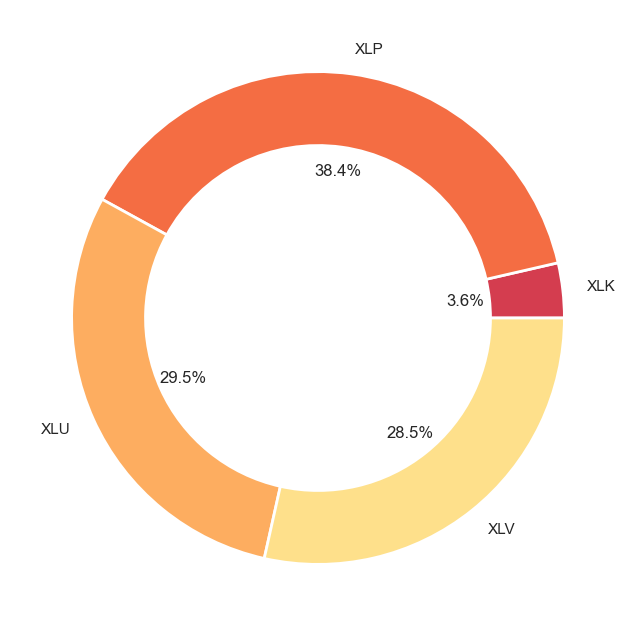

In [6]:
# 가중치 데이터프레임 변환
weights_df = pd.Series(np.round(weights, 3), index=tickers)
weights_df = weights_df[weights_df > 0.0]

# 파이차트 시각화
plt.figure(figsize=(8, 8))
wedgeprops = {'width': 0.3, 'edgecolor': 'w', 'linewidth': 2}
plt.pie(weights_df, labels=weights_df.index, autopct='%.1f%%', wedgeprops=wedgeprops, colors=pal)
plt.show()

In [7]:
cov.shape

(9, 9)

In [8]:
# GMV 포트폴리오 가중치 계산 함수
def get_gmv_weights(cov):

    # 자산 개수
    noa = cov.shape[0]

    # 초기 가중치
    init_guess = np.repeat(1/noa, noa)

    # 제약조건 및 상하한값
    bounds = ((0.0, 1.0), ) * noa
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1}

    # 목적함수: 포트폴리오 변동성
    def port_vol(weights, cov):
        vol = np.sqrt(weights.T @ cov @ weights)
        return vol

    # 최적화 수행
    res = minimize(port_vol,
                   init_guess,
                   args=(cov),
                   method='SLSQP',
                   constraints=(weights_sum_to_1,),
                   bounds=bounds)
    
    return res.x

In [9]:
# 빈 데이터프레임 생성
gmv_w_df = pd.DataFrame().reindex_like(rets)

# 공분산행렬에 대한 3차원 배열 생성
cov = rets.rolling(12).cov().fillna(0) * 12
cov = cov.values.reshape(int(cov.shape[0] / cov.shape[1]), cov.shape[1], cov.shape[1])

# 가중치 계산
for i in range(12, len(gmv_w_df)):
    gmv_w_df.iloc[i] = get_gmv_weights(cov[i-1])

Text(0, 0.5, 'Weights')

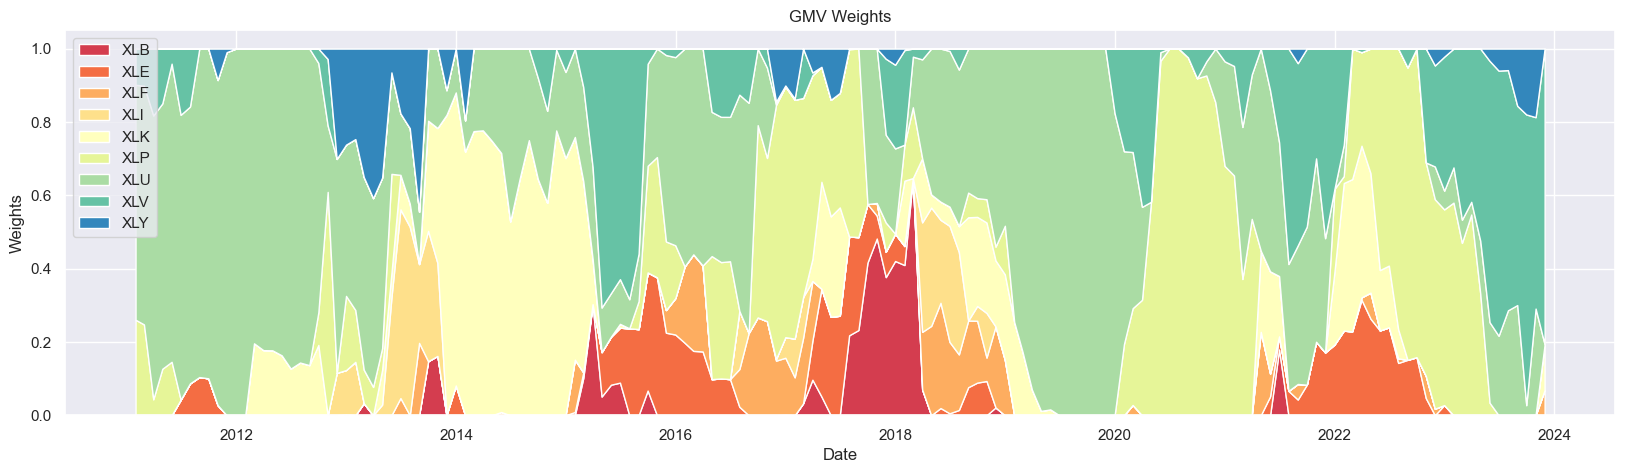

In [10]:
# 가중치 시계열 플랏
plt.figure(figsize=(20, 5))
plt.stackplot(gmv_w_df.index, gmv_w_df.T, labels=gmv_w_df.columns, colors=pal)
plt.legend(loc='upper left')
plt.title('GMV Weights')
plt.xlabel('Date')
plt.ylabel('Weights')

Text(0, 0.5, 'Returns')

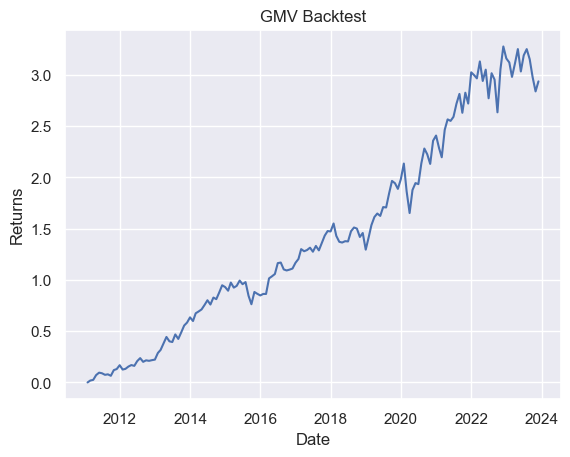

In [11]:
# GMV 포트폴리오 수익률
port_rets = gmv_w_df.shift() * rets
port_cum_rets = (1 + port_rets.sum(axis=1)).cumprod() - 1

# 포트폴리오 백테스팅 결과 그래프
plt.plot(port_cum_rets.iloc[12:])
plt.title('GMV Backtest')
plt.xlabel('Date')
plt.ylabel('Returns')

Copyright 2022. 퀀트대디. All rights reserved.